# Final Problem Set #1

Programmer: Tony Menzo

Date: 26-Apr-2019

This notebook implements the double and triple pendulum. 

# Double Pendulum 

We begin with the double pendulum. As expressed in section 11.4 of Taylor the total potential energy for a two pendulum system is given by 
$\begin{align}
U(\phi_1, \phi_2)= (m_1+m_2)gL_1(1-\cos{\phi_1})+m_2gL_2(1-\cos{\phi_2})
\end{align}$

and the total kinetic energy is given by 

$\begin{align}
T = \frac{1}{2}(m_1+m_2)L_1\dot{\phi}_1^2+m_2L_1L_2\dot{\phi}_1\dot{\phi}_2\cos{(\phi_1-\phi_2)}+\frac{1}{2}m_2L_2^2\dot{\phi}_2^2
\end{align}$

The Lagrangian is then expressed as T-U.

$
\mathcal{L} = \frac{1}{2}(m_1+m_2)L_1\dot{\phi}_1^2+m_2L_1L_2\dot{\phi}_1\dot{\phi}_2\cos{(\phi_1-\phi_2)}+\frac{1}{2}m_2L_2^2\dot{\phi}_2^2 - (m_1+m_2)gL_1(1-\cos{\phi_1})-m_2gL_2(1-\cos{\phi_2})
$

We can now find the equations of motion by solving the Euler-Lagrange equations for our two degrees of freedom $\phi_1$ and $\phi_2$.

$
\begin{align}
\frac{\partial L}{\partial \phi_n} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\phi_n}} \quad \text{for n=1,2}
\end{align}
$

For $\phi_1$ we obtain

$
(m_1+m_2)L_1^2\ddot{\phi}_1+m_2L_1L_2\ddot{\phi}_2\cos{(\phi_1-\phi_2)}+m_2L_1L_2\dot{\phi}_2^2\sin{(\phi_1-\phi_2)}=-(m_1+m_2)gL_1\sin{\phi_1}
$

and for $\phi_2$ 

$
m_2L_1L_2\ddot{\phi}_1\cos{(\phi_1-\phi_2)}+m_2L_2^2\ddot{\phi}_2-m_2L_1L_2\dot{\phi}_1^2\sin{(\phi_1-\phi_2)}=-m_2gL_2\sin{\phi_2}
$

Perhaps the most difficult part of this problem is realizing the form of the coupled first order differential equations we need for `solve_ivp`. Our $\vec{y}$ will now have four components

$
y(t) = 
\begin{pmatrix}
\phi_1 \\
\dot{\phi}_1 \\
\phi_2 \\
\dot{\phi}_2
\end{pmatrix}
$

As usual we make the substitution $\dot{\phi}_1\rightarrow z_1$, $\ddot{\phi}_1\rightarrow \dot{z}_1$ $\dot{\phi}_2\rightarrow z_2$, $\ddot{\phi}_2\rightarrow \dot{z}_2$

Thus

$
\begin{align}
\frac{d}{dt}y(t) =
\begin{pmatrix}
z_1 \\
\dot{z}_1 \\ 
z_2 \\
\dot{z}_2
\end{pmatrix}
\end{align}
$

In order to solve this using `solve_ivp` we need to express $\dot{z}_1$ and $\dot{z}_2$ in terms of $z_1,z_2, \phi_1,$ and $\phi_2$. Rewriting our equations of motion

$
(m_1+m_2)L_1 \dot{z}_1+m_2L_2\dot{z}_2 \cos{(\phi_1-\phi_2)} +m_2L_2 z_2^2\sin{(\phi_1-\phi_2)}+(m_1+m_2)g\sin{\phi_1}=0
$

$
m_2L_2\dot{z}_2+m_2L_1\dot{z}_1\cos{(\phi_1-\phi_2)}-m_2L_1 z_1^2\sin{(\phi_1-\phi_2)}+m_2 g \sin{\phi_2} =0
$

Solving this system of equations with mathematica we find the expressions for $\dot{z}_1$ and $\dot{z}_2$

$
\begin{align}
\dot{z}_1 = \frac{-g\sin{\phi_1}(2m_1+m_2) -g m_2 \sin{(\phi_1-2\phi_2)} -2 m_2 \sin{(\phi_1 - \phi_2)}\big(L_2 z_2^2+L_1  z_1^2 \cos{(\phi_1 - \phi_2)}\big) }{2L_1\bigg(m_1 + m_2 - m_2 \cos{(\phi_1 - \phi_2)}^2\bigg)}
\end{align}
$

$\begin{align}
\dot{z}_2 =\frac{\sin{(\phi_1 - \phi_2)}\bigg(L_1 (m_1 + m_2) z_1^2 + g (m_1 + m_2)\cos{\phi_1} + L_2 m_2 z_2^2 \cos{(\phi_1 - \phi_2)}\bigg)} {L_2 \big(m_1+ m_2 - m_2 \cos{(\phi_1 - \phi_2)}^2\big)}
\end{align}
$


To begin programming this system we need to import some libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Next we create our `DoublePendulum` class implementing our discussion on $\vec{y}$

In [2]:
class DoublePendulum:
    """
    DoublePendulum class implements the parameters and Lagrange's equations for 
     a double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1, L2 : float
        length of the the two arms of the double pendulum
    g : float
        gravitational acceleration at the earth's surface
    
    m1, m2 : float
        masses of the two attached pendula

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1.0, L2=1.0, g=1.0, m1=1.0, m2=1.0):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1]=dphi_1/dt, y[2]=phi_2(t) = dphi_2/dt
            
        Returns
        -------
        
        """
        return [y[1], -g*np.sin(y[0])*(2.*m1+m2)-g*m2*np.sin(y[0]-2.*y[2])
                -2.*m2*np.sin(y[0]-y[2])*(L2*y[3]**2+L1*y[1]**2*np.cos(y[0]-y[2]))/(2.*L1*(m1+m2-m2*(np.cos(y[0]-y[2]))**2)), 
                y[3],(np.sin(y[0]-y[2])*(L1*(m1+m2)*y[1]**2+g*(m1+m2)*np.cos(y[0])+L2*m2*y[3]**2*np.cos(y[0]-y[2])))/(L2*(m1+m2-m2*(np.cos(y[0]-y[2]))**2))]
        
    
    def solve_ode(self, t_pts, phi_1_0, phi_1_dot_0,phi_2_0, phi_2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1,phi_1_dot,phi_2, phi_2_dot  = solution.y

        return phi_1, phi_1_dot, phi_2, phi_2_dot

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [6]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$ (s)', r'$\phi(t)$ (rad)')
deltaPhi_vs_time_labels = (r'$t$', r'$\Delta\phi$')
state_space_labels = (r'$\phi_2$', r'$\phi_1$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a pendulum 
p1 = DoublePendulum(L1=L1, L2=L2,  g=g, m1=m1, m2=m2)

(<matplotlib.axes._subplots.AxesSubplot at 0x1187e20b8>,
 <matplotlib.lines.Line2D at 0x118b33da0>)

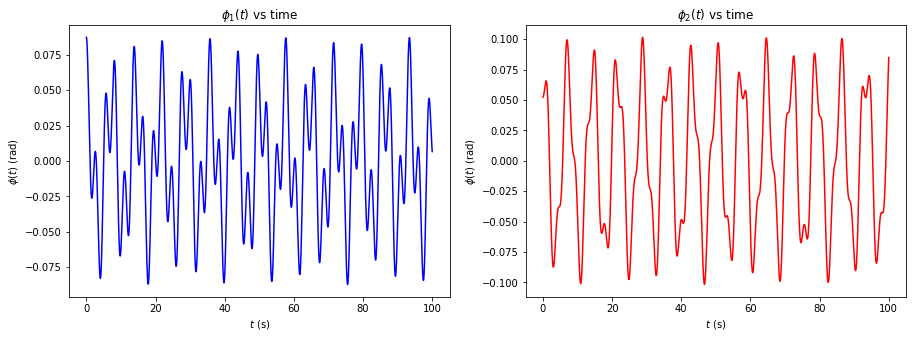

In [7]:
# give the initial conditions we'll start with small angles
phi_1_0 = 5.*(np.pi/180.)
phi_2_0 = 3.*(np.pi/180.)

# initial velocities
phi_1_dot_0 = 0.
phi_2_dot_0 = 0.

# solving the ODEs
phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0,phi_2_dot_0)

# starting the first plot
fig = plt.figure(figsize=(15,5))
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi_1(t)$ vs time', 
            ax=ax_a) 
ax_b =fig.add_subplot(1,2,2)  
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=None, 
            title=r'$\phi_2(t)$ vs time', 
            ax=ax_b) 

From these figures we can see that thess are two coupled oscillators. Let's also take a look at the phase space plot 

(<matplotlib.axes._subplots.AxesSubplot at 0x151dbc1c88>,
 <matplotlib.lines.Line2D at 0x151df22780>)

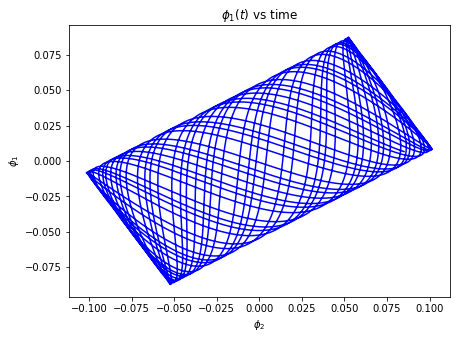

In [8]:
fig4 = plt.figure(figsize=(15,5))
    
# first plot: phi plot 
ax_a = fig4.add_subplot(1,2,1)                  


start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi_2[start : stop], phi_1[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title=r'$\phi_1(t)$ vs time', 
            ax=ax_a) 

We see that the phase space plot is nice and closed indicative of a non-chaotic system. 

For large initial angles, the sytem becomes chaotic. We can show this by solving the differential equations with slightly different initial conditions. If the system is chaotic we expect the difference $\phi_{1}-\phi_1'$ and $\phi_2-\phi_2'$ to grow with time, indicating that the motions have a stong dependence on initial conditions (tell-tle sign of chaos). We can express the difference as  

$
\Delta \phi (t) = \phi_{n}(t)-\phi_{n}'(t) \text{ for n=1,2} 
$

This can be expressed approximately as

$
\Delta \phi (t) \approx K e^{\lambda t}
$

For a chatoic system we expect $\lambda>0$

(<matplotlib.axes._subplots.AxesSubplot at 0x151df7b2b0>,
 <matplotlib.lines.Line2D at 0x151e4ec240>)

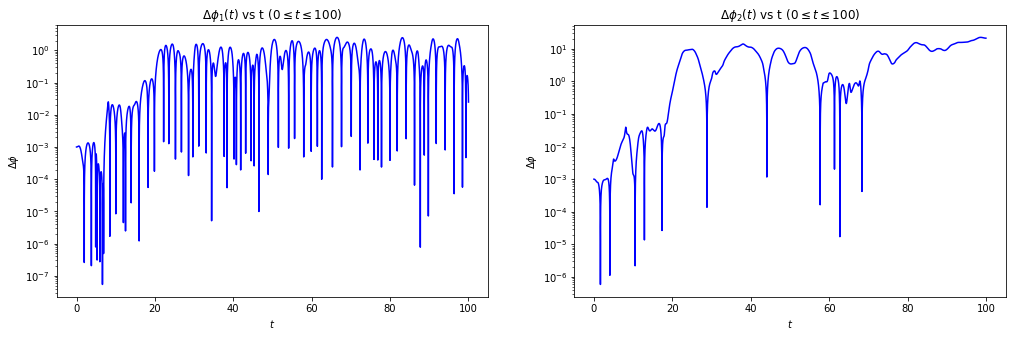

In [9]:
# give the large angle initial conditions
phi_1_0c = 85.*(np.pi/180.)
phi_2_0c = 50.*(np.pi/180.)

# slightly modified initial conditions which we will use to show chaotic behavior
phi_1_0_new = (phi_1_0c+0.001)
phi_2_0_new = (phi_2_0c+0.001)

# initial velocities
phi_1_dot_0 = 0.
phi_2_dot_0 = 0.

#solving the ODEs
# solving the ODEs
phi_1c, phi_1_dotc, phi_2c, phi_2_dotc = p1.solve_ode(t_pts, phi_1_0c, phi_1_dot_0, phi_2_0c,phi_2_dot_0)
phi_1_newc, phi_1_dot_newc, phi_2_newc, phi_2_dot_newc = p1.solve_ode(t_pts, phi_1_0_new, phi_1_dot_0, phi_2_0_new,phi_2_dot_0)

#calculate Delta phi
delta_phi1 = np.abs(phi_1_newc - phi_1c)
delta_phi2 = np.abs(phi_2_newc - phi_2c)

#make another plot to show chatoic behavior
fig1 = plt.figure(figsize=(17,5))

ax_a = fig1.add_subplot(1,2,1)                  
#Plotting the semilog plot of \Delta \phi
start, stop = start_stop_indices(t_pts, 0.0, 100.0)    
plot_y_vs_x(t_pts[start : stop], delta_phi1[start : stop], 
            axis_labels=deltaPhi_vs_time_labels, 
            color='blue',
            label=None, 
            title='$\Delta \phi_1(t)$ vs t $(0 \leq t \leq 100)$', 
            semilogy=ax_a)    


ax_b = fig1.add_subplot(1,2,2)   
#Plotting the semilog plot of \Delta \phi
start, stop = start_stop_indices(t_pts, 0.0, 100.0)    
plot_y_vs_x(t_pts[start : stop], delta_phi2[start : stop], 
            axis_labels=deltaPhi_vs_time_labels, 
            color='blue',
            label=None, 
            title='$\Delta \phi_2(t)$ vs t $(0 \leq t \leq 100)$', 
            semilogy=ax_b)    

                              

With the following phase space plot

(<matplotlib.axes._subplots.AxesSubplot at 0x151da1a048>,
 <matplotlib.lines.Line2D at 0x151da12588>)

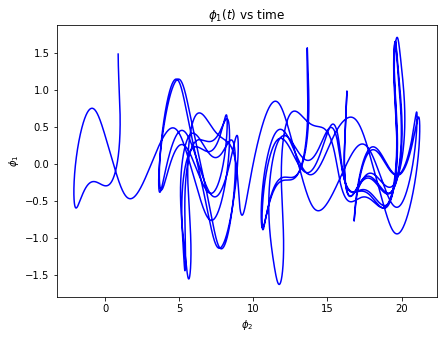

In [10]:
fig5 = plt.figure(figsize=(15,5))
    
# first plot: phi plot 
ax_a = fig5.add_subplot(1,2,1)                  


start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi_2c[start : stop], phi_1c[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title=r'$\phi_1(t)$ vs time', 
            ax=ax_a) 

We can see that $\Delta \phi_{1,2}$ both increase with time, indicating chaotic motion and we also see the unclosed phase space plot. These two pieces of evidence indicate that the double penulum at large angles is indeed chatoic.

# Triple Pendulum

As we move on to three pendulums I will make two assumptions which will greatly simplify the problem. The first is that all of the pendulum arms will have the same length L, and the second is the masses attached to the arms will have the same mass m.

First lets define some coordinates (switching to $\theta$ so we don't get confused)

$\begin{align}
x_1 = L \sin{\theta_1} \quad y_1 = -L \cos{\theta_1}
\end{align}$

$\begin{align}
x_2 = x_1 + L \sin{\theta_2} \quad y_2= -y_1 - L \cos{\theta_2}
\end{align}$

$\begin{align}
x_3 = x_2+ L \sin{\theta_3} \quad y_3= -y_2 -L\cos{\theta_3}
\end{align}$

With these coordinates we can write down the kinetic energy

$\begin{align}
T = \frac{1}{2}m_1(\dot{x}_1^2+\dot{y}_1^2)+\frac{1}{2}m_2(\dot{x}_2^2+\dot{y}_2^2)+\frac{1}{2}m_3(\dot{x}_3^2+\dot{y}_3^2)
\end{align}$

$\begin{align}
=\frac{1}{2} L^2 m \left(3 \dot{\theta }_1^2+2
   \dot{\theta }_2^2+\dot{\theta }_3^2+4 \dot{\theta }_2 \dot{\theta }_1 \cos
   \left(\theta _1-\theta _2\right)+2 \dot{\theta }_3 \dot{\theta }_1 \cos \left(\theta
   _1-\theta _3\right)+2 \dot{\theta }_2 \dot{\theta }_3 \cos \left(\theta _2-\theta
   _3\right)\right)
\end{align}$

The potential is given by 

$\begin{align}
U = m_1 g y_1 + m_2 g y_2 + m_3 g y_3
\end{align}$

$\begin{align}
= g L m \left(3 \cos \left(\theta _1\right)+2 \cos \left(\theta _2\right)+\cos
   \left(\theta _3\right)\right)
\end{align}$

Combining to get the Lagrangian

$\begin{align}
\mathcal{L}=g L m \left(3 \cos \left(\theta _1\right)+2 \cos \left(\theta _2\right)+\cos
   \left(\theta _3\right)\right)+\frac{1}{2} L^2 m \left(3 \dot{\theta }_1^2+2
   \dot{\theta }_2^2+\dot{\theta }_3^2+4 \dot{\theta }_2 \dot{\theta }_1 \cos
   \left(\theta _1-\theta _2\right)+2 \dot{\theta }_3 \dot{\theta }_1 \cos \left(\theta
   _1-\theta _3\right)+2 \dot{\theta }_2 \dot{\theta }_3 \cos \left(\theta _2-\theta
   _3\right)\right)
\end{align}$

From the Euler-Lagrange equations we can find the equations of motion. 

For $\theta_1$

$\begin{align}
\frac{1}{2} L^2 m \left(6 \ddot{\theta }_1-4 \dot{\theta }_2 \left(\dot{\theta}
   _1-\dot{\theta} _2\right) \sin \left(\theta _1-\theta _2\right)-2 \dot{\theta
   }_3 \left(\dot{\theta} _1-\dot{\theta} _3\right) \sin \left(\theta _1-\theta
   _3\right)+4 \ddot{\theta }_2 \cos \left(\theta _1-\theta _2\right)+2
   \ddot{\theta }_3 \cos \left(\theta _1-\theta _3\right)\right)=\frac{1}{2} L^2 m \left(-4 \dot{\theta }_1 \dot{\theta }_2 \sin \left(\theta _1-\theta
   _2\right)-2 \dot{\theta }_1 \dot{\theta }_3 \sin \left(\theta _1-\theta
   _3\right)\right)-3 g L m \sin \left(\theta _1\right)
\end{align}$

   
For $\theta_2$

$\begin{align}
\frac{1}{2} L^2 m \left(4 \dot{\theta }_2'(t)-4 \dot{\theta }_1(t) \left(\theta
   _1'(t)-\theta _2'(t)\right) \sin \left(\theta _1(t)-\theta _2(t)\right)-2 \dot{\theta
   }_3(t) \left(\theta _2'(t)-\theta _3'(t)\right) \sin \left(\theta _2(t)-\theta
   _3(t)\right)+4 \dot{\theta }_1'(t) \cos \left(\theta _1(t)-\theta _2(t)\right)+2
   \dot{\theta }_3'(t) \cos \left(\theta _2(t)-\theta _3(t)\right)\right)=\frac{1}{2} L^2 m \left(4 \dot{\theta }_1 \dot{\theta }_2 \sin \left(\theta _1-\theta
   _2\right)-2 \dot{\theta }_2 \dot{\theta }_3 \sin \left(\theta _2-\theta
   _3\right)\right)-2 g L m \sin \left(\theta _2\right)
\end{align}$

Finally for $\theta_3$

$\begin{align}
\frac{1}{2} L^2 m \left(2 \dot{\theta }_3'(t)-2 \dot{\theta }_1(t) \left(\theta
   _1'(t)-\theta _3'(t)\right) \sin \left(\theta _1(t)-\theta _3(t)\right)-2 \dot{\theta
   }_2(t) \left(\theta _2'(t)-\theta _3'(t)\right) \sin \left(\theta _2(t)-\theta
   _3(t)\right)+2 \dot{\theta }_1'(t) \cos \left(\theta _1(t)-\theta _3(t)\right)+2
   \dot{\theta }_2'(t) \cos \left(\theta _2(t)-\theta _3(t)\right)\right)=\frac{1}{2} L^2 m \left(2 \dot{\theta }_1 \dot{\theta }_3 \sin \left(\theta _1-\theta
   _3\right)+2 \dot{\theta }_2 \dot{\theta }_3 \sin \left(\theta _2-\theta
   _3\right)\right)-g L m \sin \left(\theta _3\right)
\end{align}$

From here we make the appropriate substitutions, $\dot{\theta}_1\rightarrow z_1$, $\ddot{\theta}_1\rightarrow \dot{z}_1$ $\dot{\theta}_2\rightarrow z_2$, $\ddot{\theta}_2\rightarrow \dot{z}_2$ and then solve for $\dot{z}_{1,2,3}$. We get

$\begin{align}
\dot{z}_1\to \frac{2 \left(g \sin \left(\theta _1-2 \theta
   _2\right)-\frac{1}{2} g \sin \left(\theta _1\right) \left(\cos \left(2 \left(\theta
   _2-\theta _3\right)\right)-5\right)+L z_1^2 \sin \left(2 \left(\theta _1-\theta
   _2\right)\right)+L z_2^2 \sin \left(\theta _1-\theta _2\right) \left(\cos
   \left(\theta _2-\theta _3\right)+2\right)\right)}{L \left(2 \cos \left(2 \left(\theta
   _1-\theta _2\right)\right)+\cos \left(2 \left(\theta _2-\theta
   _3\right)\right)-5\right)},
   \end{align}$
   
   $\begin{align}
   \dot{z}_2\to \frac{g \left(\sin \left(\theta _1+\theta
   _2-2 \theta _3\right)-7 \sin \left(\theta _1-\theta _2\right)\right) \cos
   \left(\theta _1\right)+L z_1^2 \left(\sin \left(\theta _1+\theta _2-2 \theta
   _3\right)-7 \sin \left(\theta _1-\theta _2\right)\right)+L z_2^2 \left(-2 \sin
   \left(2 \left(\theta _1-\theta _2\right)\right)-\sin \left(2 \theta _1-\theta
   _2-\theta _3\right)+3 \sin \left(\theta _2-\theta _3\right)+\sin \left(2 \left(\theta
   _2-\theta _3\right)\right)\right)}{L \left(2 \cos \left(2 \left(\theta _1-\theta
   _2\right)\right)+\cos \left(2 \left(\theta _2-\theta
   _3\right)\right)-5\right)},
   \end{align}$
   
   $\begin{align}
   \dot{z}_3\to -\frac{2 \sin \left(\theta _2-\theta
   _3\right) \left(2 g \cos \left(\theta _1\right) \cos \left(\theta _1-\theta
   _2\right)+2 L z_1^2 \cos \left(\theta _1-\theta _2\right)+L z_2^2 \left(\cos
   \left(\theta _2-\theta _3\right)+2\right)\right)}{L \left(2 \cos \left(2 \left(\theta
   _1-\theta _2\right)\right)+\cos \left(2 \left(\theta _2-\theta
   _3\right)\right)-5\right)}
\end{align}$

In [11]:
class TriplePendulum:
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L : float
        length of all three arms of the triple pendulum
    g : float
        gravitational acceleration at the earth's surface
    
    m : float
        mass of the three attached pendula

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L=1.0, g=1.0, m=1.0 ):
        self.L1 = L
        self.g = g
        self.m1 = m
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dtheta/dt d^2theta/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 6-component vector with y[0] = theta_1(t), y[1]=theta_2(t), y[2]=theta_3(t), y[3] = d(theta_1)/dt, 
            y[4] = d(theta_1)/dt, y[5] = d(theta_3)/dt
            
        Returns
        -------
        
        """
        return [y[3], y[4], y[5],
                (2.*(g*np.sin(y[0]-2*y[1])-0.5*g*np.sin(y[0])*(np.cos(2.*(y[1]-y[2]))-5.)+L*y[3]**2.*np.sin(2.*(y[0]-y[1]))
                +L*y[4]**2.*np.sin(y[0]-y[1])*(np.cos(y[1]-y[2])+2.)))/(L*(2.*np.cos(2.*(y[0]-y[1]))+np.cos(2.*(y[1]-y[2]))-5.)),
               (g*(np.sin(y[0]+y[1]-2.*y[2])-7.*np.sin(y[0]-y[1]))*np.cos(y[0])+L*y[3]**2.*(np.sin(y[0]+y[1]-2.*y[2])-7.*np.sin(y[0]-y[1]))
                +L*y[4]**2.*(-2.*np.sin(2.*(y[0]-y[1]))-np.sin(2.*y[0]-y[1]-y[2])+3.*np.sin(y[1]-y[2])+np.sin(2.*(y[1]-y[2]))))
                /(L*(2.*np.cos(2.*(y[0]-y[1]))+np.cos(2.*(y[1]-y[2]))-5.)),
                -(2.*np.sin(y[1]-y[2])*(2.*g*np.cos(y[0]-y[1])+2.*L*y[3]**2.*np.cos(y[0]-y[1])+L*y[4]**2.*(np.cos(y[1]-y[2])+2.)))
                /(L*(2.*np.cos(2.*(y[0]-y[1]))+np.cos(2.*(y[1]-y[2]))-5.))]
       
    
    def solve_ode(self, t_pts, theta_1_0, theta_2_0,theta_3_0, theta_1_dot_0, theta_2_dot_0, theta_3_dot_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [theta_1_0, theta_2_0,theta_3_0, theta_1_dot_0, theta_2_dot_0, theta_3_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        theta_1, theta_2, theta_3, theta_1_dot, theta_2_dot, theta_3_dot  = solution.y

        return theta_1, theta_2, theta_3, theta_1_dot, theta_2_dot, theta_3_dot

In [12]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')
theta_dot_vs_time_labels = (r'$t$', r'$d\theta/dt(t)$')
state_space_labels = (r'$\theta_2$', r'$\theta_1$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L = 1.
g = 1.
m = 1.


# Instantiate a triple pendulum 
p1 = TriplePendulum(L=L, g=g, m=m)

(<matplotlib.axes._subplots.AxesSubplot at 0x1520692ac8>,
 <matplotlib.lines.Line2D at 0x15206ac908>)

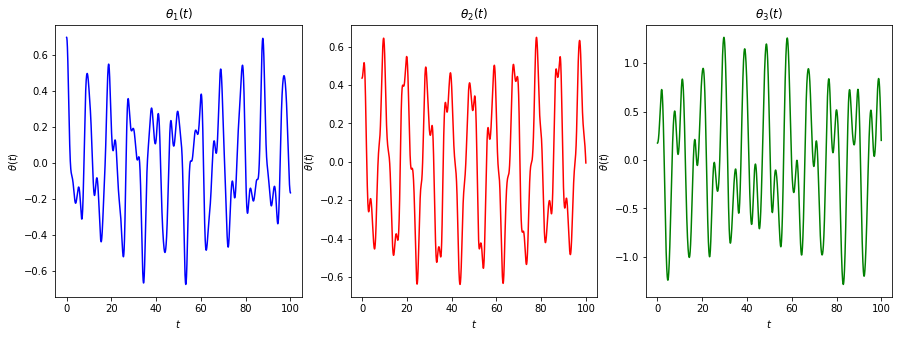

In [13]:
# initial conditions
#position
theta_1_0 = 40.*(np.pi/180.)
theta_2_0 = 25.*(np.pi/180.)
theta_3_0 = 10.*(np.pi/180.)

# initial velocity
theta_1_dot_0 = 0.
theta_2_dot_0 = 0.
theta_3_dot_0 = 0.

#solving
theta_1, theta_2, theta_3, theta_1_dot, theta_2_dot, theta_3_dot = p1.solve_ode(t_pts, theta_1_0, theta_2_0,theta_3_0, theta_1_dot_0, theta_2_dot_0,theta_3_dot_0)

# start another plot
fig2 = plt.figure(figsize=(15,5))
    
# theta plots 
ax_a2 = fig2.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta_1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\theta_1(t)$', 
            ax=ax_a2) 
ax_b2 =fig2.add_subplot(1,3,2)  
plot_y_vs_x(t_pts[start : stop], theta_2[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='red',
            label=None, 
            title=r'$\theta_2(t)$', 
            ax=ax_b2) 
ax_c2 =fig2.add_subplot(1,3,3)  
plot_y_vs_x(t_pts[start : stop], theta_3[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='green',
            label=None, 
            title=r'$\theta_3(t)$', 
            ax=ax_c2) 

We can see that we have three coupled pendulums!!

# My attempt at animating

In attempting to animate I modified a script from SciPython.com

https://scipython.com/blog/the-double-pendulum/

I was able to produce snapshots of the pendulum but I couldn't figure out how convert the images into a continous gif or mp4 file.

In [14]:
from matplotlib.patches import Circle #allows me to create the cirlces for the pendulum animation

import os
os.mkdir('./snapshots_triplePend/') #make a folder in the current directory where we will save the snapshots

In [ ]:
# first we convert the pendulum positions to cartesian coordinates
x1 = L * np.sin(theta_1)
y1 = -L * np.cos(theta_1)
x2 = x1 + L * np.sin(theta_2)
y2 = y1 - L * np.cos(theta_2)
x3 = x2 + L * np.sin(theta_3)
y3 = y2 - L * np.cos(theta_3)

#circle radius of the penulum masses
r = 0.05

def make_plot(i):
    # Plot and save an image of the triple pendulum configuration for time
    # point i.
    
    # Create the pendulum rods.
    ax.plot([0, x1[i], x2[i], x3[i]], [0, y1[i], y2[i],y3[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1,2 and bobs 1, 2, and 3.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    c3 = Circle((x3[i], y3[i]), r, fc='g', ec='g', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)
    ax.add_patch(c3)
    
    # fix the center and set our axis lengths
    ax.set_xlim(-3*L-r, 3*L+r)
    ax.set_ylim(-3*L-r, 3*L+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('./snapshots_triplePend/_img{:04d}.png'.format(i//di), dpi=72)
    plt.cla()


# Make an image every di time points, corresponding to a frame rate (fps)
fps = 10 #10 frames per second
di = int(1/fps/delta_t)  
fig3 = plt.figure(figsize=(8., 6.), dpi=72)
ax = fig3.add_subplot(1,1,1)


for i in range(0, t_pts.size, di):
    #print(i // di, '/', t_pts.size // di)
    make_plot(i)
#this should take about 30 seconds, once it has executed, look in the snapshots_triplePend 
#folder to see the snapshots in time of the triple pendulum